In [1]:
import math
import os

import torch
from torch import optim
from torch.nn import functional as F
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

import lpips
from model import Generator
import numpy as np
from util import *

os.environ['KMP_DUPLICATE_LIB_OK']='True'
device = 'cuda'

c:\Users\Brad\anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: [WinError 127] 지정된 프로시저를 찾을 수 없습니다
  warn(f"Failed to load image Python extension: {e}")


In [2]:
def gaussian_loss(v):
    # [B, 9088]
    loss = (v-gt_mean) @ gt_cov_inv @ (v-gt_mean).transpose(1,0)
    return loss.mean()

def get_lr(t, initial_lr, rampdown=0.25, rampup=0.05):
    lr_ramp = min(1, (1 - t) / rampdown)
    lr_ramp = 0.5 - 0.5 * math.cos(lr_ramp * math.pi)
    lr_ramp = lr_ramp * min(1, t / rampup)

    return initial_lr * lr_ramp

def make_image(tensor):
    return (
        tensor.detach()
        .clamp_(min=-1, max=1)
        .add(1)
        .div_(2)
        .mul(255)
        .type(torch.uint8)
        .permute(0, 2, 3, 1)
        .to('cpu')
        .numpy()
    )

In [3]:
resize = 256

transform = transforms.Compose([
        transforms.Resize(resize),
        # transforms.CenterCrop(resize),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

In [4]:
generator1 = Generator(resize, 512, 8)
# ensure_checkpoint_exists('face.pt')
generator1.load_state_dict(torch.load('face.pt')['g_ema'], strict=False)
generator1 = generator1.to(device).eval()

In [5]:
generator2 = Generator(resize, 512, 8)
# ensure_checkpoint_exists('disney.pt')
generator2.load_state_dict(torch.load('disney.pt')['g_ema'], strict=False)
generator2 = generator2.to(device).eval()

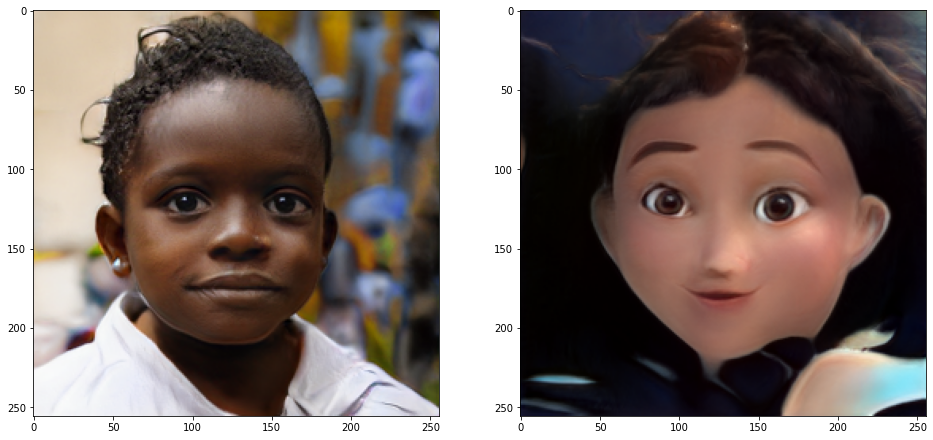

In [14]:
sample_latent1 = generator1.get_latent(torch.randn([1, 512]).to(device), is_latent=False)
sample_latent2 = generator2.get_latent(torch.randn([1, 512]).to(device), is_latent=False)

im1 = tensor2image(generator1(sample_latent1)[0])
im2 = tensor2image(generator2(sample_latent2)[0])

fig, axes = plt.subplots(1, 2, figsize=(16, 16))
axes[0].imshow(im1)
axes[1].imshow(im2)

In [15]:
percept = lpips.LPIPS(net='vgg', spatial=True).to(device)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [on]
Loading model from: c:\Users\Brad\anaconda3\lib\site-packages\lpips\weights\v0.1\vgg.pth


In [16]:
# get gaussian stats
if not os.path.isfile('inversion_stats.npz'):
    with torch.no_grad():
        source = list2style(generator1.get_latent(torch.randn([10000, 512]).cuda())).cpu().numpy()
        gt_mean = source.mean(0)
        gt_cov = np.cov(source, rowvar=False)

    # We show that style space follows gaussian distribution
    # An extension from this work https://arxiv.org/abs/2009.06529
    np.savez('inversion_stats.npz', mean=gt_mean, cov=gt_cov)

data = np.load('inversion_stats.npz')
gt_mean = torch.tensor(data['mean']).cuda().view(1,-1).float()
gt_cov_inv = torch.tensor(data['cov']).cuda()

# Only take diagonals
mask = torch.eye(*gt_cov_inv.size()).cuda()
gt_cov_inv = torch.inverse(gt_cov_inv*mask).float()

In [17]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

from retinaface import RetinaFace
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import math

img_path = 'imgs/02.jpg'

resp = RetinaFace.detect_faces(img_path)

print(resp)

{'face_1': {'score': 0.9995378255844116, 'facial_area': [180, 318, 356, 562], 'landmarks': {'right_eye': [227.14113, 422.11807], 'left_eye': [306.81784, 404.04086], 'nose': [276.61295, 456.1311], 'mouth_right': [248.85922, 504.7256], 'mouth_left': [318.36603, 489.5488]}}}


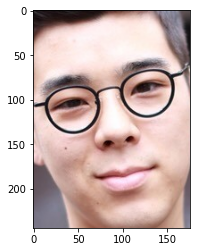

In [18]:
import cv2

img = cv2.imread(img_path)
img = img[:, :, ::-1]

facial_area = resp['face_1']['facial_area']
landmarks = resp['face_1']["landmarks"]
left_eye = landmarks["left_eye"]
right_eye = landmarks["right_eye"]
nose = landmarks["nose"]
mouth_right = landmarks["mouth_right"]
mouth_left = landmarks["mouth_left"]

face_img = img[facial_area[1]: facial_area[3], facial_area[0]: facial_area[2]]

plt.imshow(face_img)

12.782971344213877


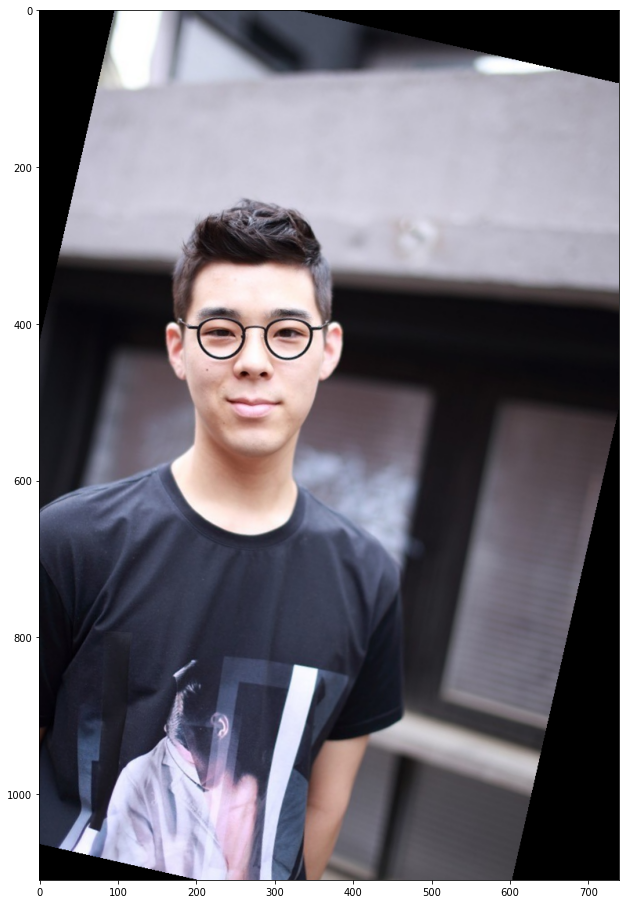

In [19]:
# swap
left_eye, right_eye = right_eye, left_eye

left_eye_x, left_eye_y = left_eye
right_eye_x, right_eye_y = right_eye

center_eyes = (int((left_eye_x + right_eye_x) / 2), int((left_eye_y + right_eye_y) / 2))

if left_eye_y > right_eye_y:
    point_3rd = (right_eye_x, left_eye_y)
    direction = -1 #rotate same direction to clock
else:
    point_3rd = (left_eye_x, right_eye_y)
    direction = 1 #rotate inverse direction of clock

#-----------------------
#find length of triangle edges

a = np.linalg.norm(np.array(left_eye) - np.array(point_3rd))
b = np.linalg.norm(np.array(right_eye) - np.array(point_3rd))
c = np.linalg.norm(np.array(right_eye) - np.array(left_eye))

if b != 0 and c != 0: #this multiplication causes division by zero in cos_a calculation
    cos_a = (b*b + c*c - a*a)/(2*b*c)
    
    #PR15: While mathematically cos_a must be within the closed range [-1.0, 1.0], floating point errors would produce cases violating this
    #In fact, we did come across a case where cos_a took the value 1.0000000169176173, which lead to a NaN from the following np.arccos step
    cos_a = min(1.0, max(-1.0, cos_a))
    
    
    angle = np.arccos(cos_a) #angle in radian
    angle = (angle * 180) / math.pi #radian to degree

    #-----------------------
    #rotate base image

    if direction == -1:
        angle = 90 - angle

    rotated_img = Image.fromarray(img)
    rotated_img = np.array(rotated_img.rotate(direction * angle, center=nose, resample=Image.Resampling.BILINEAR))

    if center_eyes[1] > nose[1]:
        rotated_img = Image.fromarray(rotated_img)
        rotated_img = np.array(rotated_img.rotate(180))

print(angle)
plt.figure(figsize=(16, 16))
plt.imshow(rotated_img)

(366, 366, 3)


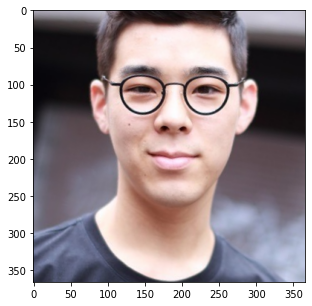

In [20]:
w, h = facial_area[2] - facial_area[0], facial_area[3] - facial_area[1]
cx, cy = (facial_area[0] + facial_area[2]) / 2, (facial_area[1] + facial_area[3]) / 1.8

margin_ratio = 1.5

crop_size = max(w, h) * margin_ratio

x1 = max(0, int(cx - crop_size / 2))
x2 = int(cx + crop_size / 2)
y1 = max(0, int(cy - crop_size / 2))
y2 = int(cy + crop_size / 2)

face_img = rotated_img[y1:y2, x1:x2]

print(face_img.shape)
plt.figure(figsize=(5, 5))
plt.imshow(face_img)

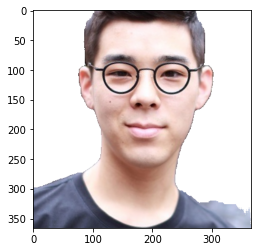

In [21]:
import mediapipe as mp

mp_selfie_segmentation = mp.solutions.selfie_segmentation

selfie_segmentation = mp_selfie_segmentation.SelfieSegmentation(model_selection=0)

results = selfie_segmentation.process(face_img)

mask = (np.stack((results.segmentation_mask,) * 3, axis=-1) > 0.5).astype(np.float32)
back_img = np.full_like(face_img, 255) * (1. - mask)
fore_img = face_img * mask
face_img = (fore_img + back_img).astype(np.uint8)

plt.imshow(face_img)

In [22]:
face_input = transform(Image.fromarray(face_img)).unsqueeze(0).to(device)

face_input.shape

torch.Size([1, 3, 256, 256])

In [23]:
step = 300 #1000
lr = 1 # 1
lr_reduce_interval = 50 # 200
lr_reduce_ratio = 0.2 # 0.2

with torch.no_grad():
    latent_mean = generator1.mean_latent(50000)
    latent_in = list2style(latent_mean)

latent_in.requires_grad = True

optimizer = optim.Adam([latent_in], lr=lr, betas=(0.9, 0.999))

In [24]:
perceptual_weight = 50 # 500 ori 50
mse_weight = 500 # 1
g_weight = 1e-3 # 1e-3

min_latent = None
min_loss = 10000
pbar = tqdm(range(step))
latent_path = []
losses = []

for i in pbar:
    t = i / step
#     lr = get_lr(t, lr)
    if i > 0 and i % lr_reduce_interval == 0:
        lr *= lr_reduce_ratio
    latent_n = latent_in

    img_gen, _ = generator1(style2list(latent_n))

    batch, channel, height, width = img_gen.shape

    if height > resize:
        img_gen = F.interpolate(img_gen, size=(resize,resize), mode='area')

    p_loss = perceptual_weight*percept(img_gen, face_input).mean()
    mse_loss = mse_weight*F.mse_loss(img_gen, face_input)
    g_loss = g_weight*gaussian_loss(latent_n)

    loss = p_loss + mse_loss + g_loss
    losses.append(loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i + 1) % 100 == 0:
        latent_path.append(latent_in.detach().clone())
        
    if loss.item() < min_loss:
        min_loss = loss.item()
        min_latent = latent_in.detach().clone()

    pbar.set_description(
        (
            f'loss: {loss.item():.4f}; '
            f'perceptual: {p_loss.item():.4f}; '
            f'mse: {mse_loss.item():.4f}; gaussian: {g_loss.item():.4f} lr: {lr:.4f}'
        )
    )
    
latent_path.append(latent_in.detach().clone()) # last latent vector

print(min_loss)

loss: 15.6922; perceptual: 4.4058; mse: 3.6073; gaussian: 7.6791 lr: 0.0003: 100%|██████████| 300/300 [00:17<00:00, 16.90it/s]   

15.692193984985352


299


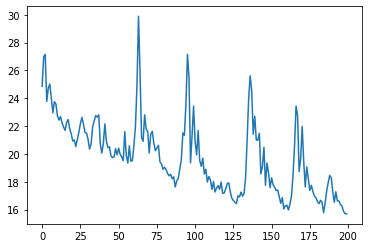

In [25]:
print(losses.index(min(losses)))
plt.plot(losses[100:])

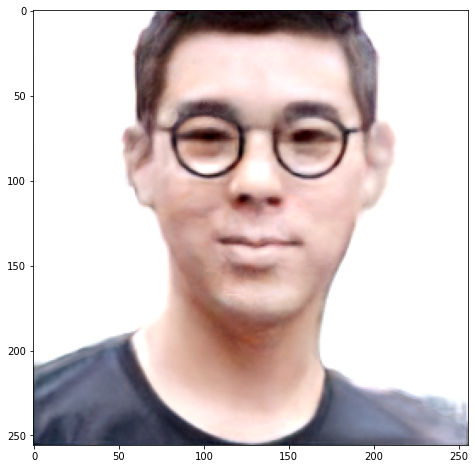

In [26]:
img_gen, _ = generator1(style2list(latent_path[-1]))

plt.figure(figsize=(8, 8))
plt.imshow(make_image(img_gen)[0])

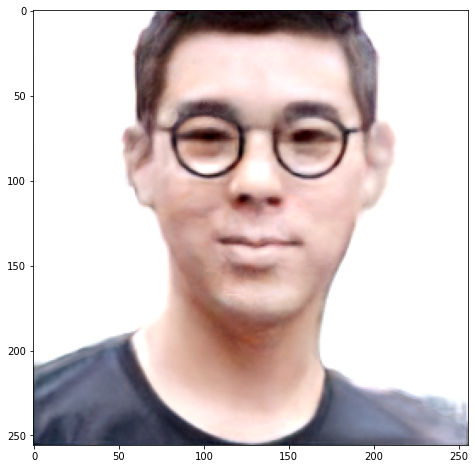

In [27]:
img_gen, _ = generator1(style2list(min_latent))

plt.figure(figsize=(8, 8))
plt.imshow(make_image(img_gen)[0])

In [28]:
def toonify(latent1, latent2, num_swap=6, early_alpha=0.0, alpha=0.5):
    with torch.no_grad():
        noise1 = [getattr(generator1.noises, f'noise_{i}') for i in range(generator1.num_layers)]
        noise2 = [getattr(generator2.noises, f'noise_{i}') for i in range(generator2.num_layers)]

        out1 = generator1.input(latent1[0])
        out2 = generator2.input(latent2[0])
        out = (1-early_alpha)*out1 + early_alpha*out2

        out1, _ = generator1.conv1(out, latent1[0], noise=noise1[0])
        out2, _ = generator2.conv1(out, latent2[0], noise=noise2[0])
        out = (1-early_alpha)*out1 + early_alpha*out2

        skip1 = generator1.to_rgb1(out, latent1[1])
        skip2 = generator2.to_rgb1(out, latent2[1])
        skip = (1-early_alpha)*skip1 + early_alpha*skip2

        i = 2
        for conv1_1, conv1_2, noise1_1, noise1_2, to_rgb1, conv2_1, conv2_2, noise2_1, noise2_2, to_rgb2 in zip(
            generator1.convs[::2], generator1.convs[1::2], noise1[1::2], noise1[2::2], generator1.to_rgbs,
            generator2.convs[::2], generator2.convs[1::2], noise2[1::2], noise2[2::2], generator2.to_rgbs
        ):


            conv_alpha = early_alpha if i < num_swap else alpha
            out1, _ = conv1_1(out, latent1[i], noise=noise1_1)
            out2, _ = conv2_1(out, latent2[i], noise=noise2_1)
            out = (1-conv_alpha)*out1 + conv_alpha*out2
            i += 1

            conv_alpha = early_alpha if i < num_swap else alpha
            out1, _ = conv1_2(out, latent1[i], noise=noise1_2)
            out2, _ = conv2_2(out, latent2[i], noise=noise2_2)
            out = (1-conv_alpha)*out1 + conv_alpha*out2
            i += 1

            conv_alpha = early_alpha if i < num_swap else alpha
            skip1 = to_rgb1(out, latent1[i], skip)
            skip2 = to_rgb2(out, latent2[i], skip)
            skip = (1-conv_alpha)*skip1 + conv_alpha*skip2

            i += 1

    image = skip.clamp(-1,1)
    
    return image

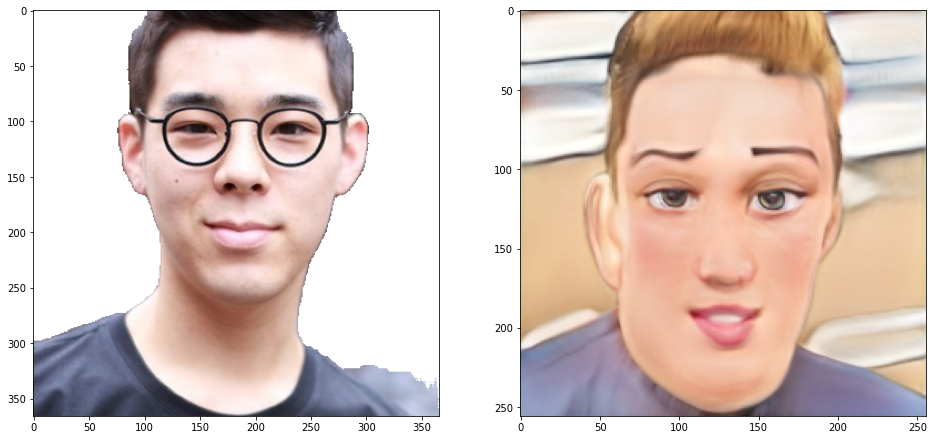

In [29]:
truncation = 0.5
seed = 0

num_swap =  9 # 6
early_alpha = 0.1 # 0
alpha =  0.75 # 0.5

with torch.no_grad():
    latent_mean2 = generator2.mean_latent(50000)

torch.manual_seed(seed)
reference_code = torch.randn([1, 512]).to(device)
latent2 = generator2.get_latent(reference_code, truncation=truncation, mean_latent=latent_mean2)

result = toonify(style2list(min_latent), latent2, num_swap, early_alpha, alpha)

virtual_img = tensor2image(result)

fig, axes = plt.subplots(1, 2, figsize=(16, 16))
axes[0].imshow(face_img)
axes[1].imshow(virtual_img)

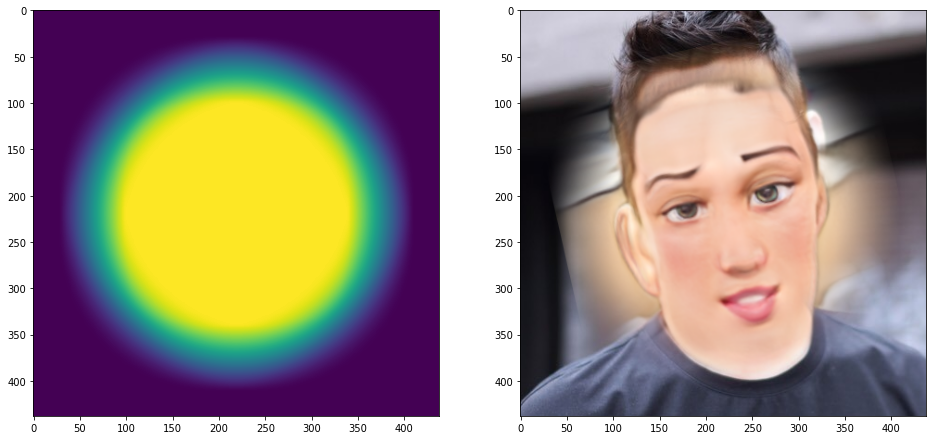

In [30]:
margin_size = int(crop_size * 0.1)

rotated_virtual_img = cv2.resize(virtual_img, dsize=(x2-x1, y2-y1))
rotated_virtual_img = cv2.copyMakeBorder(rotated_virtual_img, margin_size, margin_size, margin_size, margin_size, cv2.BORDER_CONSTANT, 0)

rotate_center = (int(nose[0] - x1 + margin_size), int(nose[1] - y1 + margin_size))

rotated_virtual_img = Image.fromarray(rotated_virtual_img)
rotated_virtual_img = rotated_virtual_img.rotate(-direction * angle, center=rotate_center, resample=Image.Resampling.BILINEAR)
rotated_virtual_img = np.array(rotated_virtual_img)

result_img = img.copy()

def alphaBlend(img1, img2, mask):
    """ alphaBlend img1 and img 2 (of CV_8UC3) with mask (CV_8UC1 or CV_8UC3)
    """
    if mask.ndim==3 and mask.shape[-1] == 3:
        alpha = mask/255.
    else:
        alpha = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR) / 255.

    img1 = cv2.cvtColor(img1, cv2.COLOR_RGBA2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_RGBA2RGB)

    blended = cv2.convertScaleAbs(img1*(1-alpha) + img2*alpha)
    return blended

new_w = x2 - x1 + 2 * margin_size
new_h = y2 - y1 + 2 * margin_size

mask = np.zeros((new_h, new_w), np.uint8)
cv2.circle(mask, (int(new_w / 2), int(new_h / 2)), int(new_w / 2.8), (255,255,255), -1, cv2.LINE_AA)
mask = cv2.GaussianBlur(mask, (71, 71), 51)

r = alphaBlend(result_img[y1-margin_size:y2+margin_size, x1-margin_size:x2+margin_size], rotated_virtual_img, mask)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].imshow(mask)
axes[1].imshow(r)

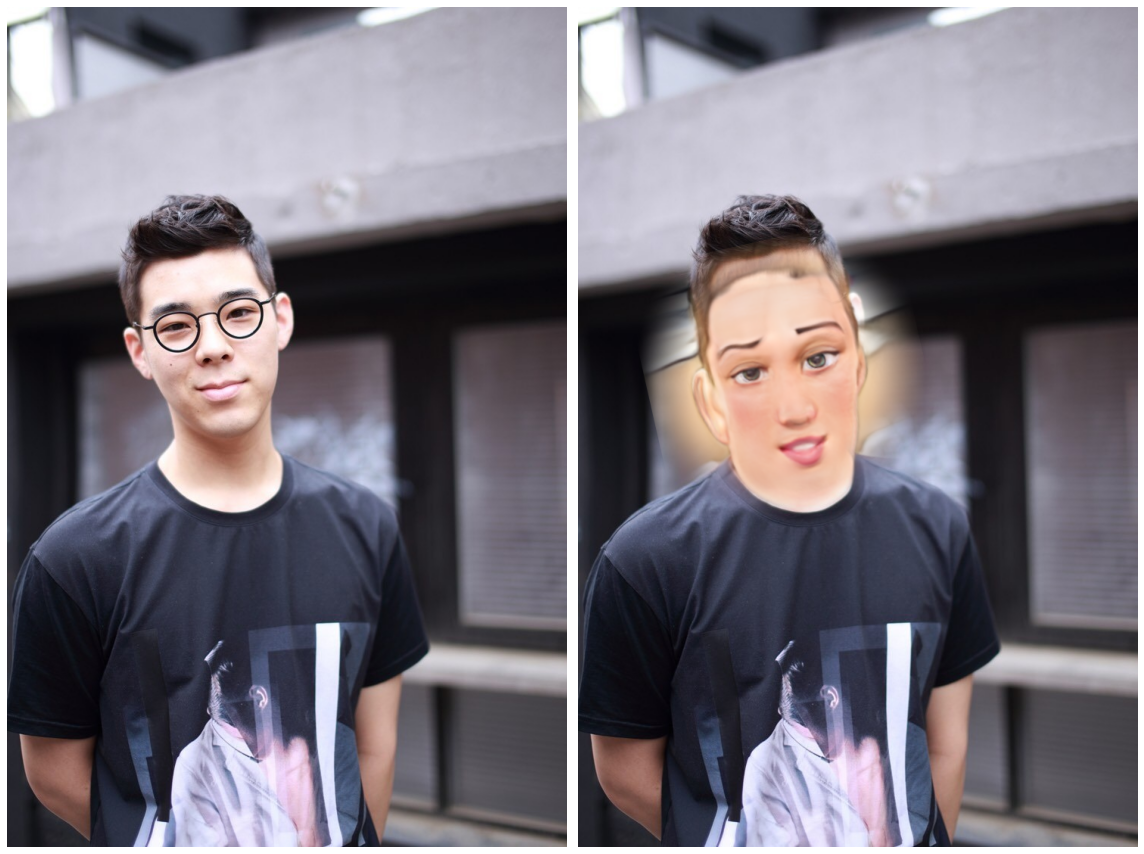

In [31]:
result_img[y1-margin_size:y2+margin_size, x1-margin_size:x2+margin_size] = r

fig, axes = plt.subplots(1, 2, figsize=(16, 16))
axes[0].imshow(img)
axes[1].imshow(result_img)
axes[0].axis('off')
axes[1].axis('off')
fig.tight_layout()
plt.show()